In [56]:
# make sure correct versions are installed/loaded!
# only relevant for clustering task (changes due to package upgrade might affect results of word clouds/clusters)
# uncomment to downgrade package to initial version during project analysis

# !pip uninstall scikit-learn -y
# !pip install scikit-learn==0.23.0

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path

#Preprocessing
from scipy.stats import pearsonr, mode 

#clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#plots
import seaborn as sns
from matplotlib import pyplot as plt

#custom functions
from functions import getResponses, chooseData, chooseEmb, getEmbeddings, getData, predModel, corrUserBased #general auxiliary function
from functions import compareModels, modelPerformance #model training and comparison
from functions import compareModelsConstructs, modelPerformanceConstruct, compareModelsKey, modelPerformanceKey, contextAccuracy, contextAccuracy_constr #construct/key prediction functions

#random state
randState = 0

#warning messages
import warnings
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")

## Construct/Item similarities

Check if items in same constructs are more similar than items across constructs, using pairwise cosine similarity of item embeddings (average pairwise similarity for same construct vs across construct item pairs).





BIG5
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     103.5
Date:                Wed, 07 Jun 2023   Prob (F-statistic):          3.28e-104
Time:                        16:18:10   Log-Likelihood:                 2757.0
No. Observations:                4950   AIC:                            -5502.
Df Residuals:                    4944   BIC:                            -5463.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2898      0.007     41.358

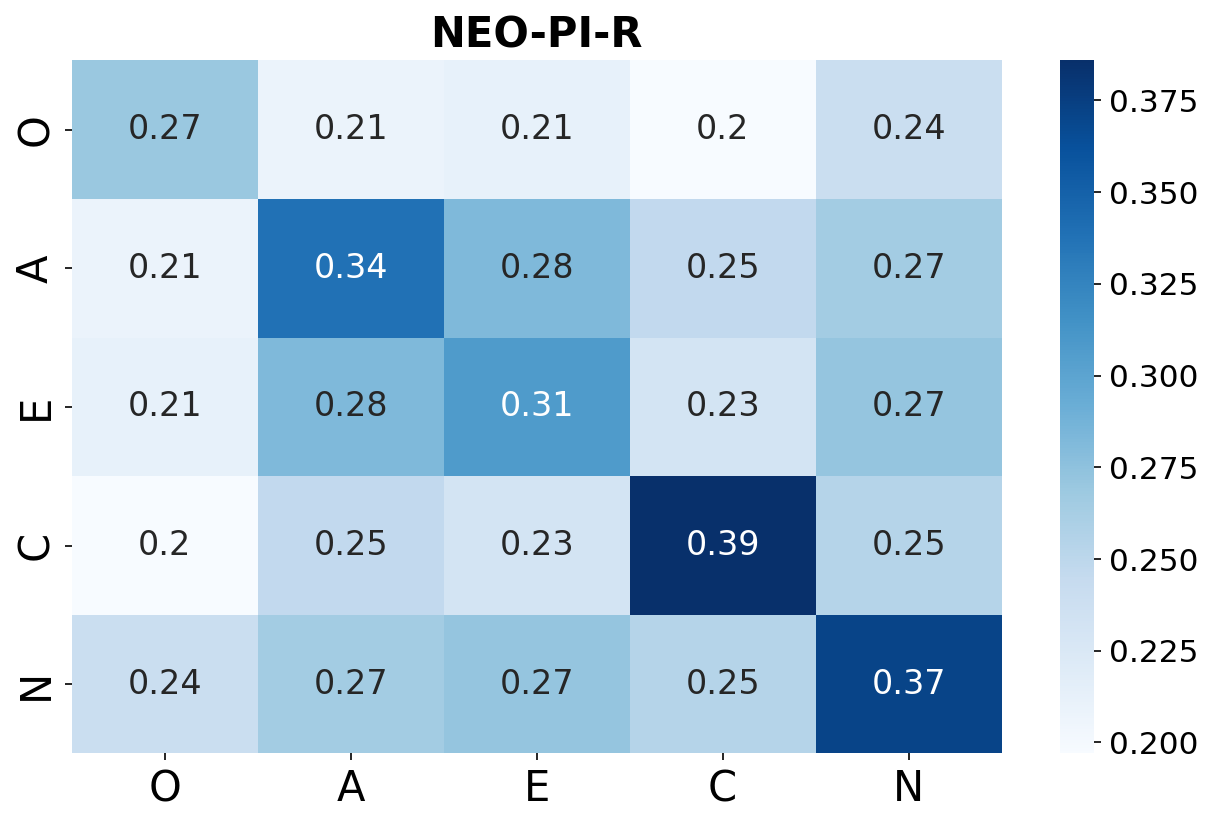

['Affiliative', 'Self-\nenhancing', 'Aggressive', 'Self-\ndefeating']




HSQ
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     8.744
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           7.98e-07
Time:                        16:18:11   Log-Likelihood:                 244.77
No. Observations:                 496   AIC:                            -479.5
Df Residuals:                     491   BIC:                            -458.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

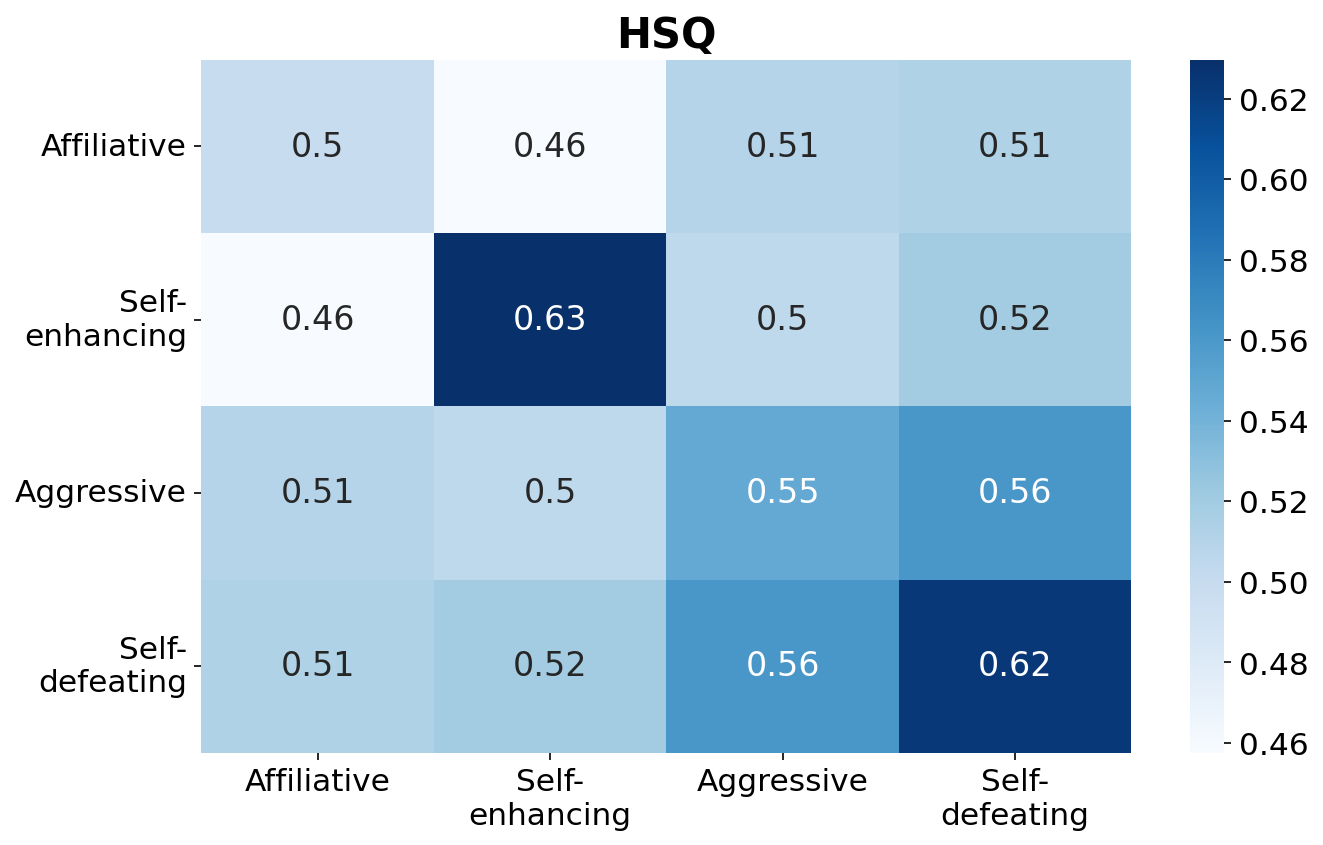

Index(['Realistic', 'Investigative', 'Artistic', 'Social', 'Enterprising',
       'Conventional'],
      dtype='object')




RIASEC
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     66.10
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           1.99e-70
Time:                        16:18:39   Log-Likelihood:                 1044.5
No. Observations:                1128   AIC:                            -2075.
Df Residuals:                    1121   BIC:                            -2040.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025 

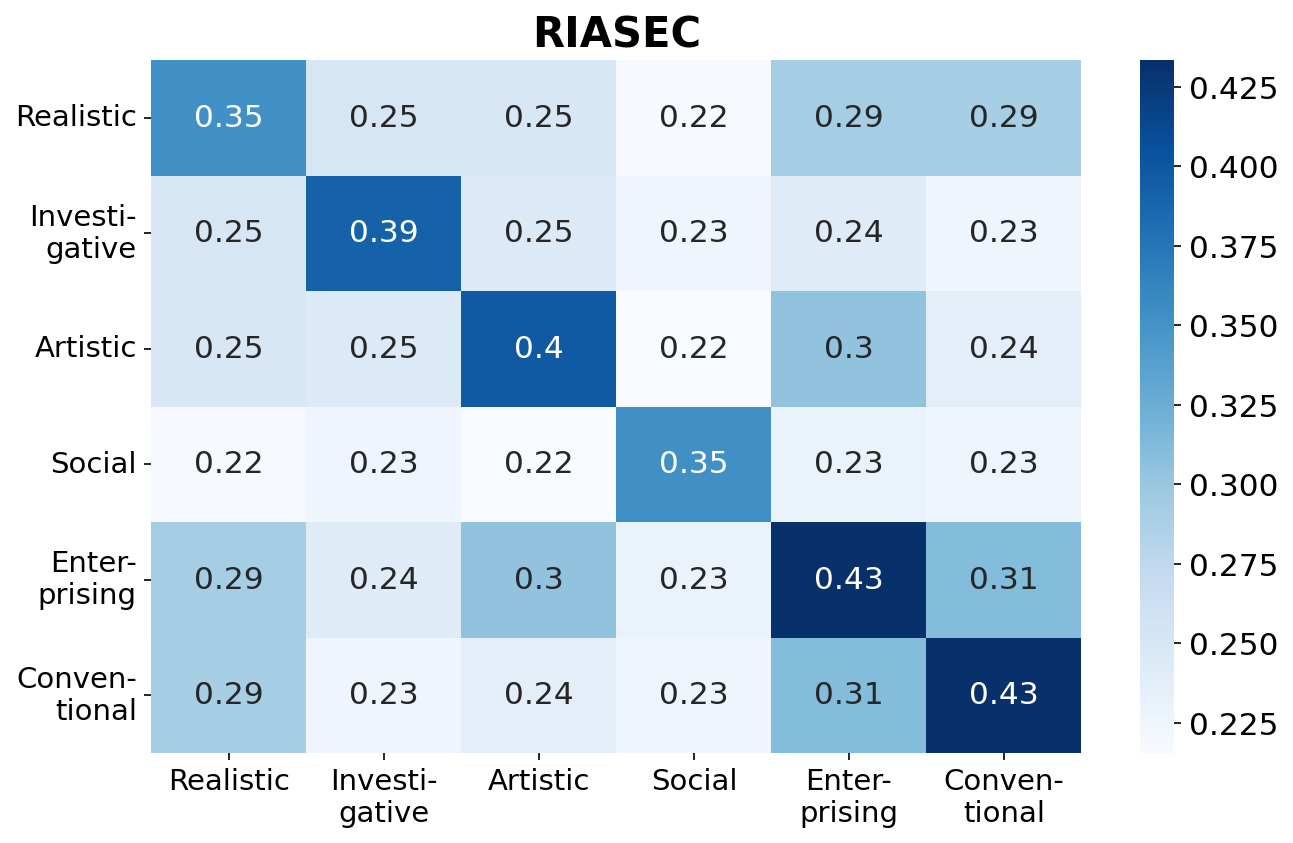





16PF
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     58.10
Date:                Wed, 07 Jun 2023   Prob (F-statistic):          5.09e-181
Time:                        16:18:52   Log-Likelihood:                 7540.5
No. Observations:               13203   AIC:                        -1.505e+04
Df Residuals:                   13186   BIC:                        -1.492e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3316      0.007     47.313

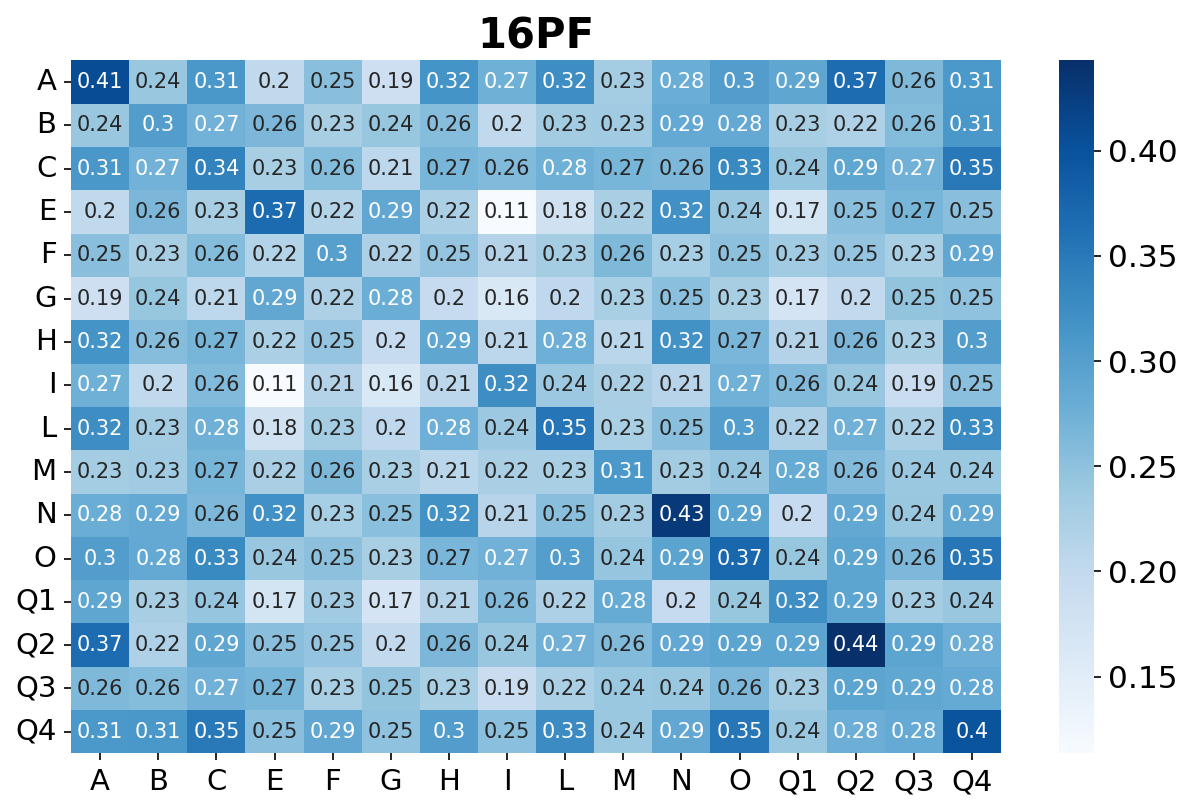

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.formula.api as sm
import itertools

# BIG5

#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
datasets = ["BIG5", 'HSQ', 'RIASEC', "16PF"]
# d = "BIG5"      #BIG5, 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 
hsq_dict = {'affiliative': "affilia-\ntive", 'selfenhancing': "self-\nenhancing", 'aggressive': "aggres-\nsive", 
            'selfdefeating': "self-\ndefeating"}

#load path and necessary variables:
for d in datasets:
  folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
  embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
  responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
  responses = responses.astype(float) #get observed responses as floats
  X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings, responses)

  # import required data and labels:
  data_q, constructs_list, list_par, constrAssigned = getData(m, responses, X_pca_stand, folder, data)

  #calculate construct similarities
  item_values = pd.DataFrame(columns=constructs_list, index=constructs_list)
  item_groups = pd.DataFrame(columns=constructs_list, index=constructs_list)
  sim_df = pd.DataFrame(columns=constructs_list, index=constructs_list)

  for constr_A in constructs_list:
    idx_A = np.where(constrAssigned.construct == constr_A)[0]
    for constr_B in constructs_list:
      idx_B = np.where(constrAssigned.construct == constr_B)[0]
      if constr_B == constr_A:
        sim = cosine_similarity(X.iloc[idx_A], X.iloc[idx_B])
        similarity_cleaned = []
        for i in range(sim.shape[0]):
          temp = sim[i][i+1:]
          similarity_cleaned.extend(temp)
        sim = similarity_cleaned
        similarity = np.array(sim).mean()
        item_values.loc[constr_A, constr_B] = sim        #save item level similarity over the whole constructs
        item_groups.loc[constr_A, constr_B] = [constr_A + "-" + constr_B]*len(sim)
      else:
        sim = cosine_similarity(X.iloc[idx_A], X.iloc[idx_B])
        similarity = sim.mean()
        item_values.loc[constr_A, constr_B] = sim.flatten().tolist()        #save item level similarity over the whole constructs
        item_groups.loc[constr_A, constr_B] = [constr_A + "-" + constr_B]*len(sim.flatten().tolist())
      sim_df.loc[constr_A, constr_B] = similarity      #save average similarity
  sim_df = sim_df.astype(float)
  sim_df.columns = [x.capitalize() for x in sim_df.columns]
  sim_df.index = [x.capitalize() for x in sim_df.index]

  # change construct name to make it shorter to fit into figure
  if d=="BIG5":
    construct_list = sim_df.columns
  elif d=="HSQ":
    construct_list = sim_df.columns
    construct_list = ["Self-\nenhancing" if item=="Selfenhancing" else item for item in construct_list]
    construct_list = ["Self-\ndefeating" if item=="Selfdefeating" else item for item in construct_list]
    sim_df.columns = construct_list
    sim_df.index = construct_list
  elif d=="RIASEC":
    construct_list = sim_df.columns
    print(construct_list)
    construct_list = ["Investi-\ngative" if item=="Investigative" else item for item in construct_list]
    construct_list = ["Enter-\nprising" if item=="Enterprising" else item for item in construct_list]
    construct_list = ["Conven-\ntional" if item=="Conventional" else item for item in construct_list]
    sim_df.columns = construct_list
    sim_df.index = construct_list
  if d=="16PF":  
    construct_list = sim_df.columns 


  #show plots
  fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
  if d=="BIG5":
    # sns.set(font_scale=1.5)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":16})
    plt.title("NEO-PI-R", fontweight="bold", fontsize=20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="HSQ":
    # sns.set(font_scale=1.5)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":16})
    plt.title("HSQ", fontweight="bold", fontsize=20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="RIASEC":
    # sns.set(font_scale=1.3)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":15})
    plt.title("RIASEC", fontweight="bold", fontsize=20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="16PF":
    # sns.set(font_scale=0.7)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":10})
    plt.title("16PF", fontweight="bold", fontsize=20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
    
  ########################### test for significance:

  print("\n\n\n")
  print(d)

  outclass_values = []
  outclass_groups = []
  inclass_values = []
  inclass_groups = []

  for n in range(len(constructs_list)):
    if n!= len(constructs_list)-1:
      outclass_values.extend(list(itertools.chain.from_iterable(item_values.iloc[n+1:,n]))) #items below diagonal are between constructs (matrix is symmetric so only take values below diagonal)
      outclass_groups.extend(list(itertools.chain.from_iterable(item_groups.iloc[n+1:,n]))) #get the names of the item pairs' constructs
    inclass_values.extend(item_values.iloc[n,n]) #values on the diagonal are within construct
    inclass_groups.extend(item_groups.iloc[n,n]) 

  outclass_df = pd.DataFrame(columns=["in_class", "similarity", "construct_1", "construct_2"])
  outclass_df.similarity = outclass_values
  outclass_df.construct_1 = [x.split("-")[0] for x in outclass_groups]
  outclass_df.construct_2 = [x.split("-")[1] for x in outclass_groups]
  outclass_df.in_class = [0]*len(outclass_values)
  
  inclass_df = pd.DataFrame(columns=["in_class", "similarity", "construct_1", "construct_2"])
  inclass_df.similarity = inclass_values
  inclass_df.construct_1 = [x.split("-")[0] for x in inclass_groups]
  inclass_df.construct_2 = [x.split("-")[1] for x in inclass_groups]
  inclass_df.in_class = [1]*len(inclass_values)
  merged_df = pd.concat([inclass_df,outclass_df])
  
  c1 = pd.get_dummies(merged_df["construct_1"])
  c2 = pd.get_dummies(merged_df["construct_2"])
  combined = c1 | c2

  final_df = pd.concat([merged_df.iloc[:,:-2], combined], axis=1)

  model = sm.ols(formula = "similarity ~ in_class + " + "+".join(constructs_list[:-1]), data=final_df)
  res = model.fit()
  A = np.identity(len(res.params))[1:,:]
  print(res.summary())
  print('R2: ', res.rsquared)
  print(res.f_test(A))  

  #save figures
  fig_name = "../plot_data/similarities_" + d + ".pdf"
  # plt.title(d, fontsize=20, fontweight="bold")
  plt.savefig(fig_name, bbox_inches='tight')

  plt.show()

## Construct/Direction Prediction Task

### Find Best Model

In [2]:
compareModelsKey(verbose = 1) #best model ridge c=1000

MODEL: RidgeClass (par = 1) SENTENCEBERT:
Correct classifications across all folds:  0.94


MODEL: RidgeClass (par = 10) SENTENCEBERT:
Correct classifications across all folds:  0.95


MODEL: RidgeClass (par = 100) SENTENCEBERT:
Correct classifications across all folds:  0.95


MODEL: RidgeClass (par = 1000) SENTENCEBERT:
Correct classifications across all folds:  0.95


MODEL: RidgeClass (par = 10000) SENTENCEBERT:
Correct classifications across all folds:  0.91


MODEL: KNN (par = 1) SENTENCEBERT:
Correct classifications across all folds:  0.89


MODEL: KNN (par = 5) SENTENCEBERT:
Correct classifications across all folds:  0.92


MODEL: KNN (par = 10) SENTENCEBERT:
Correct classifications across all folds:  0.93


MODEL: KNN (par = 15) SENTENCEBERT:
Correct classifications across all folds:  0.89


ERROR with Model: KNN, par = 50
MODEL: KNN (par = 50) SENTENCEBERT:
Correct classifications across all folds:  0.5


MODEL: SVC (par = 1) SENTENCEBERT:
Correct classifications across all f

1

### Calculate model performances (only run once/if not already saved)

#### Construct Prediction

BIG5

In [ ]:
#fit a single model with specified parameter, report performance
# main model
modelPerformanceConstruct(m=1, par=1000, d="BIG5", e="sentencebert", verbose=1) 
#baseline: Word2Vec
modelPerformanceConstruct(m=1, par=1000, d="BIG5", e="word2vec", verbose=1) 
modelPerformanceConstruct(m=1, par=1000, d="BIG5", e="liwc", verbose=1)

#m-> 0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

In [ ]:
modelPerformanceConstruct(m=1, par=1000, d="BIG5", e="sentencebert", verbose=1) 

16PF

In [ ]:
#fit a single model with specified parameter, report performance
# main model
modelPerformanceConstruct(m=1, par=1000, d="16PF", e="sentencebert", verbose=1) 
#baseline: Word2Vec
modelPerformanceConstruct(m=1, par=1000, d="16PF", e="word2vec", verbose=1)
#baseline: LIWC
modelPerformanceConstruct(m=1, par=1000, d="16PF", e="liwc", verbose=1) 

RIASEC

In [ ]:
#fit a single model with specified parameter, report performance
# main model
modelPerformanceConstruct(m=1, par=1000, d="RIASEC", e="sentencebert", verbose=1) 
#baseline: Word2Vec
modelPerformanceConstruct(m=1, par=1000, d="RIASEC", e="word2vec", verbose=1) 
#baseline: LIWC
modelPerformanceConstruct(m=1, par=1000, d="RIASEC", e="liwc", verbose=1) 

HSQ

In [ ]:
#fit a single model with specified parameter, report performance
# main model
modelPerformanceConstruct(m=1, par=1000, d="HSQ", e="sentencebert", verbose=1) 
#baseline: Word2Vec
modelPerformanceConstruct(m=1, par=1000, d="HSQ", e="word2vec", verbose=1) 
#baseline: LIWC
modelPerformanceConstruct(m=1, par=1000, d="HSQ", e="liwc", verbose=1) 

IPIP

In [ ]:
#fit a single model with specified parameter, report performance
# main model
modelPerformanceConstruct(m=1, par=1000, d="ipip2", e="sentencebert", verbose=1) 
#baseline: Word2Vec
modelPerformanceConstruct(m=1, par=1000, d="ipip2", e="word2vec", verbose=1)
#baseline: LIWC
modelPerformanceConstruct(m=1, par=1000, d="ipip2", e="liwc", verbose=1)

#### Direction Prediction

BIG5

In [22]:
#fit a single model with specified parameter, report performance
# main model
modelPerformanceKey(m=1, par=10, d="BIG5", e="sentencebert", verbose=1) 
#baseline: Word2Vec
modelPerformanceKey(m=1, par=10, d="BIG5", e="word2vec", verbose=1)
#baseline: LIWC
modelPerformanceKey(m=1, par=10, d="BIG5", e="liwc", verbose=1) 
#m-> 0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

MODEL: RidgeClass (par = 10) SENTENCEBERT:
Correct classifications across all folds:  0.95


MODEL: RidgeClass (par = 10) WORD2VEC:
Correct classifications across all folds:  0.54


MODEL: RidgeClass (par = 10) LIWC:
Correct classifications across all folds:  0.61




1

16PF

In [23]:
#fit a single model with specified parameter, report performance
# main model
modelPerformanceKey(m=1, par=10, d="16PF", e="sentencebert", verbose=1) 
#baseline: Word2Vec
modelPerformanceKey(m=1, par=10, d="16PF", e="word2vec", verbose=1)
#baseline: LIWC
modelPerformanceKey(m=1, par=10, d="16PF", e="liwc", verbose=1)

#m-> 0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

MODEL: RidgeClass (par = 10) SENTENCEBERT:
Correct classifications across all folds:  0.945


MODEL: RidgeClass (par = 10) WORD2VEC:
Correct classifications across all folds:  0.583


MODEL: RidgeClass (par = 10) LIWC:
Correct classifications across all folds:  0.509




1

HSQ

In [24]:
#fit a single model with specified parameter, report performance
# main model
modelPerformanceKey(m=1, par=10, d="HSQ", e="sentencebert", verbose=1) 
#baseline: Word2Vec
modelPerformanceKey(m=1, par=10, d="HSQ", e="word2vec", verbose=1)
#baseline: LIWC
modelPerformanceKey(m=1, par=10, d="HSQ", e="liwc", verbose=1)

#m-> 0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

MODEL: RidgeClass (par = 10) SENTENCEBERT:
Correct classifications across all folds:  1.0


MODEL: RidgeClass (par = 10) WORD2VEC:
Correct classifications across all folds:  0.875


MODEL: RidgeClass (par = 10) LIWC:
Correct classifications across all folds:  0.906




1

### Plot model performance for construct and direction prediction tasks

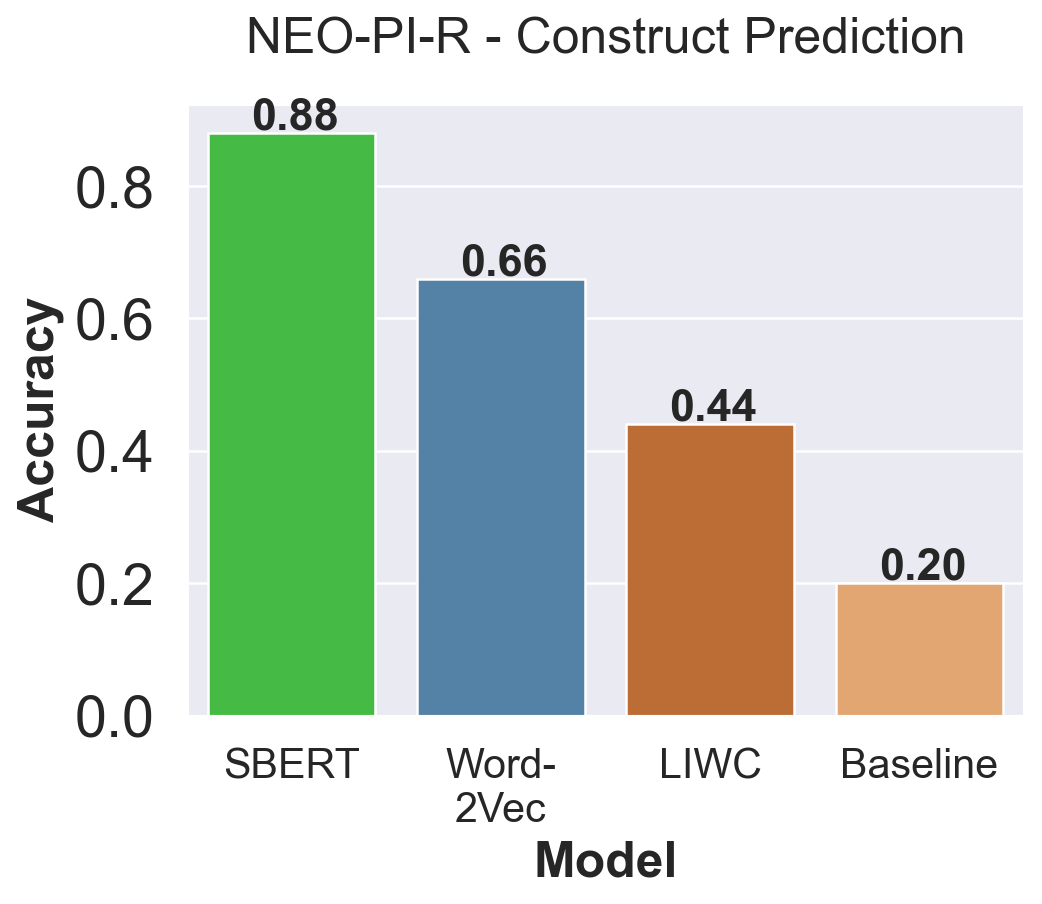

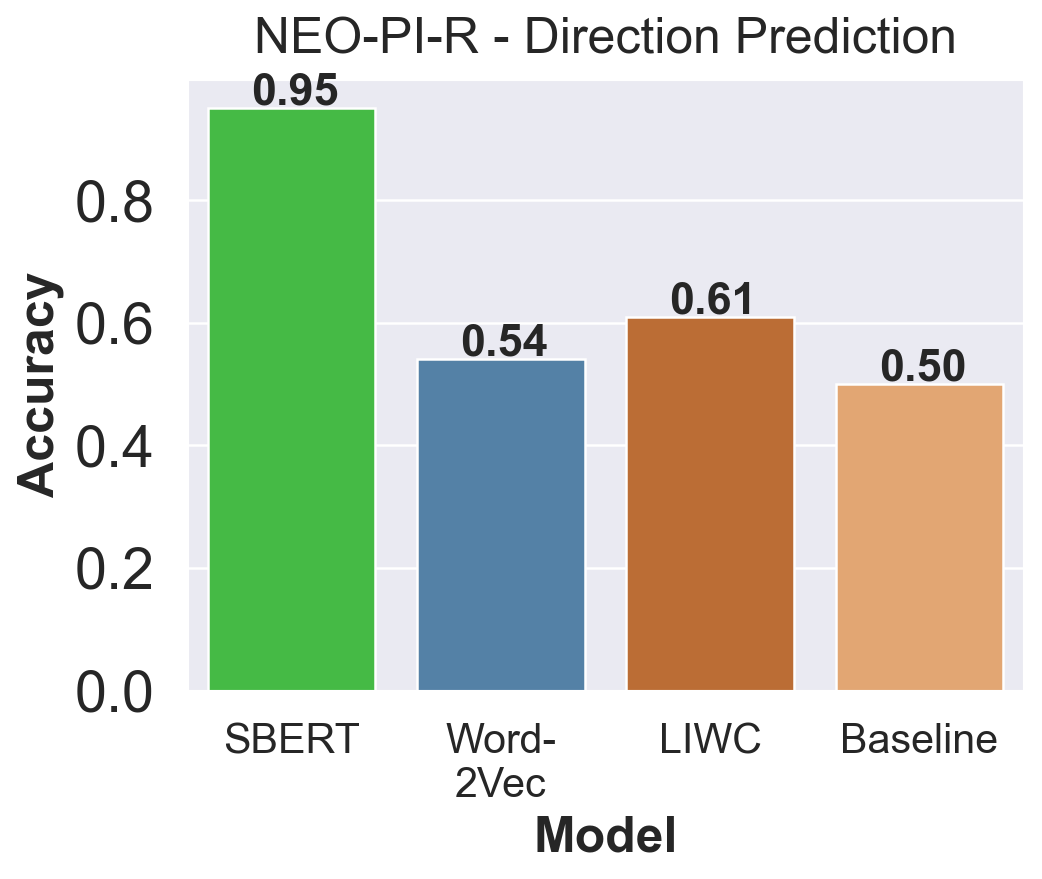

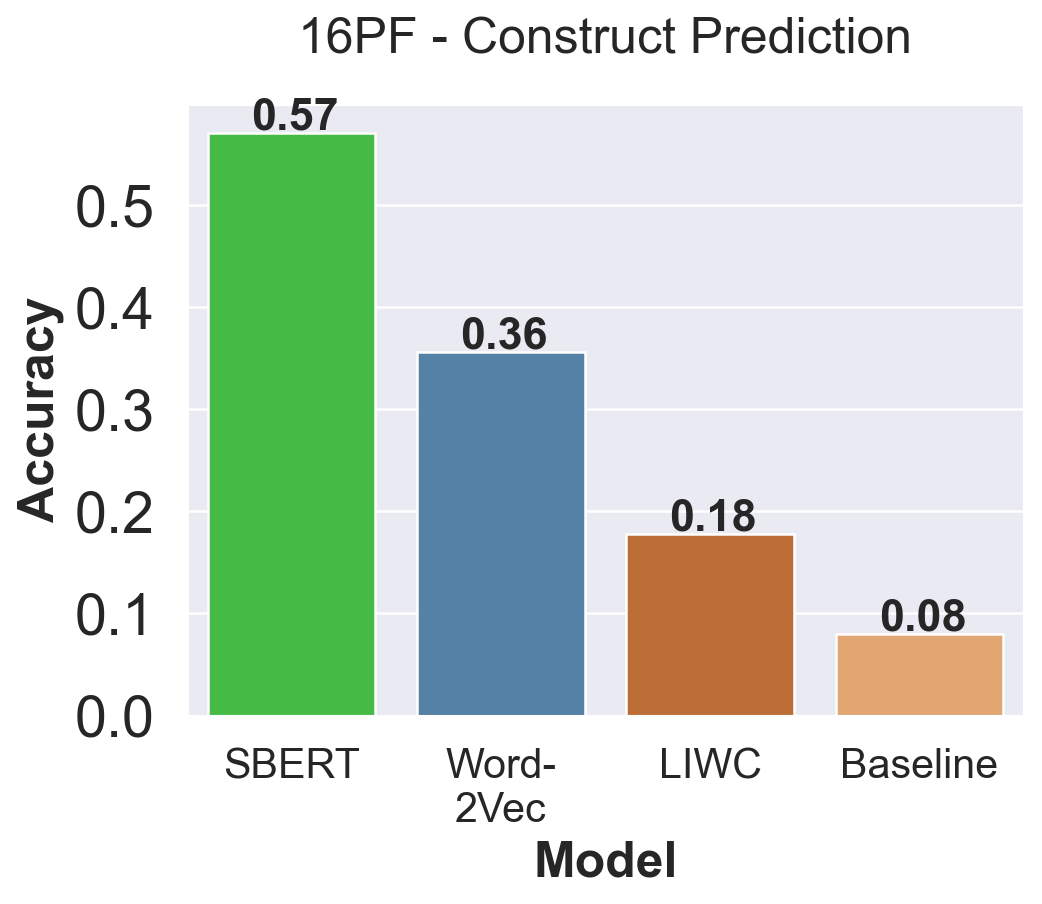

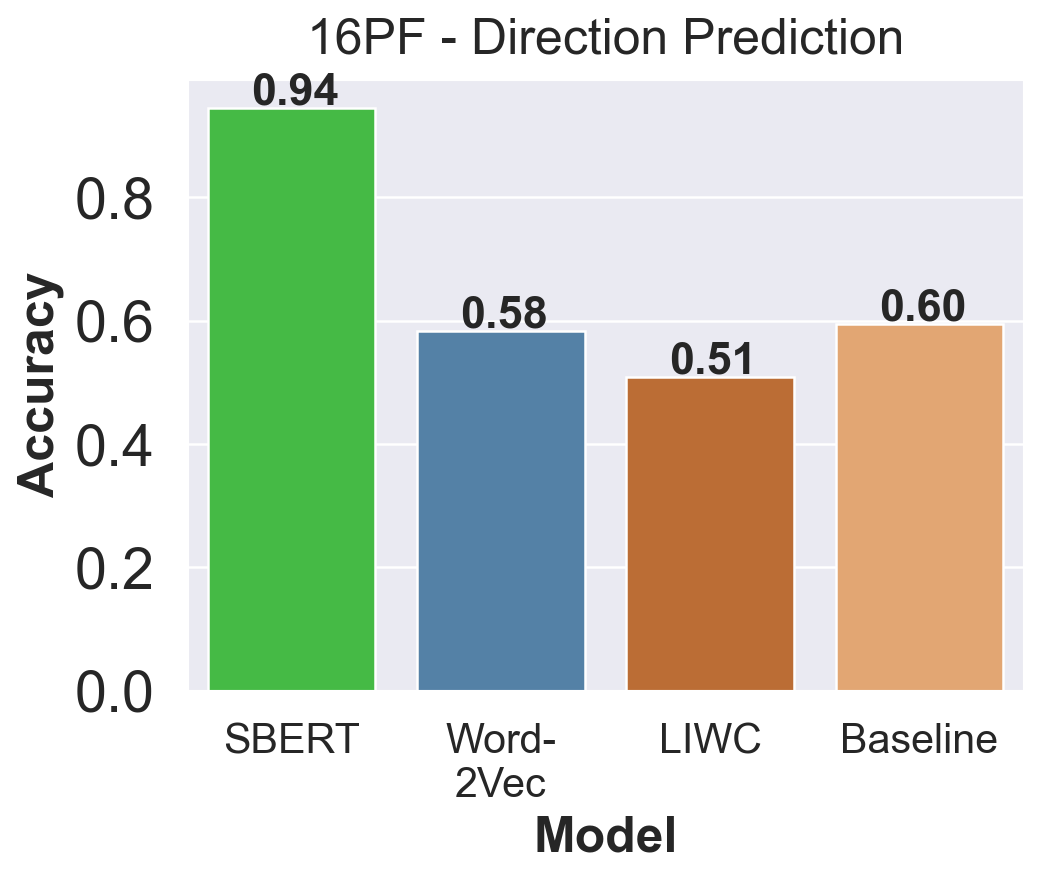

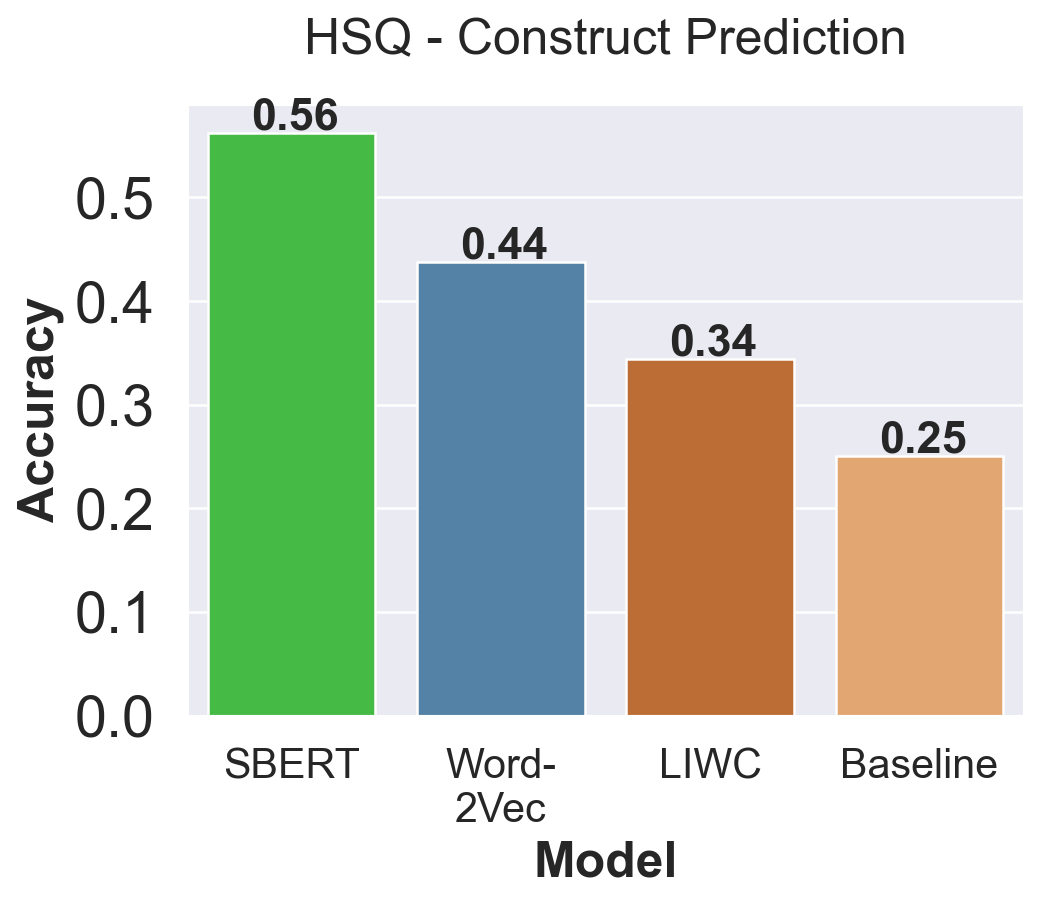

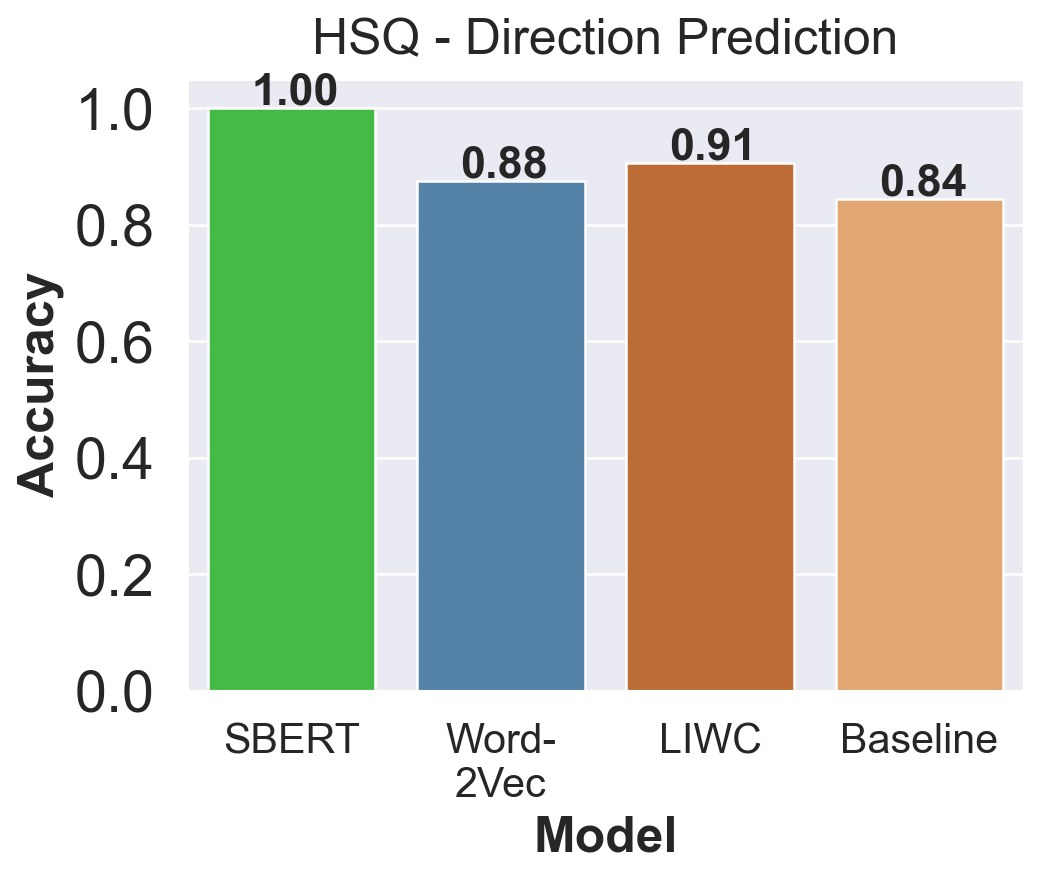

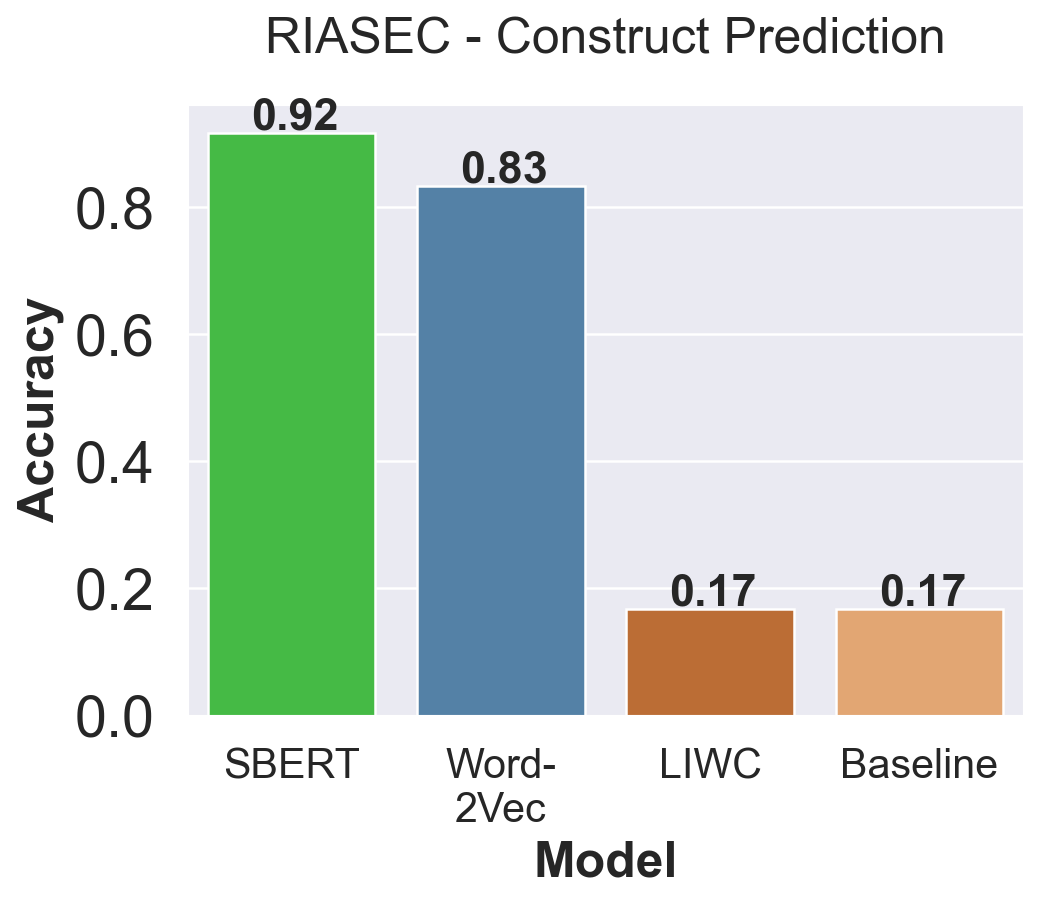

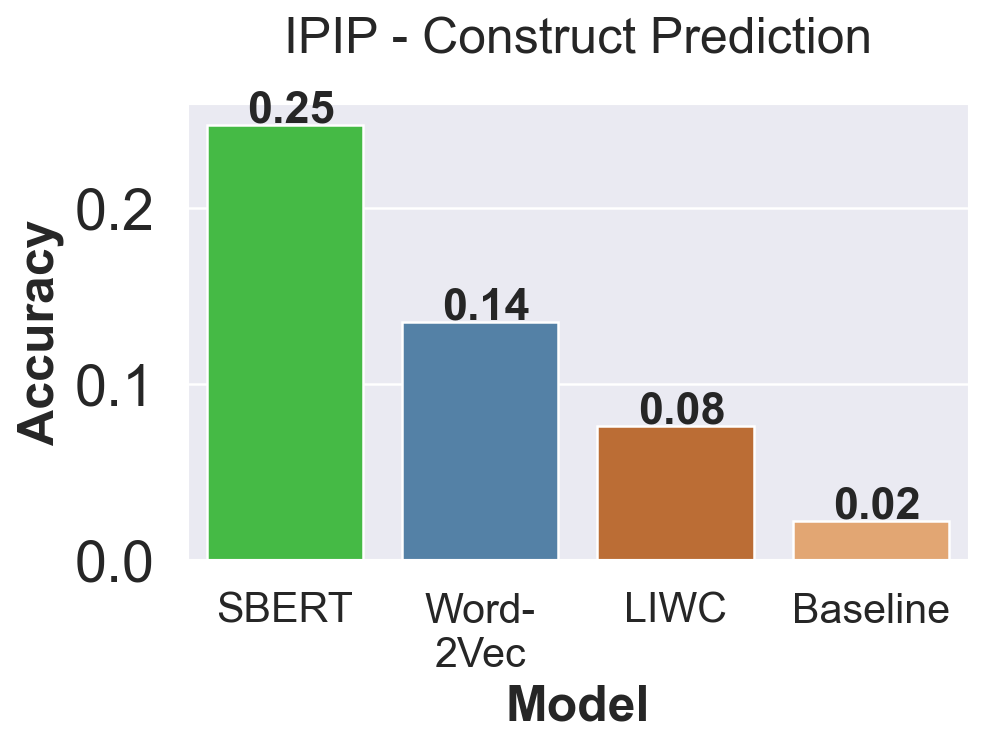

In [4]:
#new bar plots:
datasets_con = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP2']
datasets_dir = ['BIG5', '16PF', 'HSQ']
names_con = ['NEO-PI-R', '16PF', 'HSQ', 'RIASEC', 'IPIP']
names_dir = ['NEO-PI-R', '16PF', 'HSQ']
performance_con = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])
performance_dir = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])

#iterate through datasets for construct data
for i,nr in zip(datasets_con, range(len(datasets_con))):
  results_con = contextAccuracy("construct", i)
  performance_con = pd.concat([performance_con, results_con], ignore_index=True)

#iterate through datasets for direction data
for i,nr in zip(datasets_dir, range(len(datasets_dir))):
  results_dir = contextAccuracy("keys", i)
  performance_dir = pd.concat([performance_dir, results_dir], ignore_index=True)

cols = performance_con.columns.drop(['Dataset', 'Target', 'Model'])
performance_con[cols] = performance_con[cols].astype(float)
performance_dir[cols] = performance_dir[cols].astype(float)

performance_con['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_con['Model']]
performance_dir['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_dir['Model']]
performance_con['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_con['Model']]
performance_dir['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_dir['Model']]

#Plot style and meta
plt.style.use('seaborn-v0_8')
sns.set_context('paper')
sns.set(font_scale = 1.5)

l=0 #for labelling of the panels (if only one type of plot is plotted)
for i in range(5):
    # fig.add_subplot(5, 2, 2*i+1)
    fig  = plt.figure(figsize=(6, 4.5), dpi= 180)
    ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "Word-\n2Vec", "LIWC", "Baseline"] , orient='v', data=performance_con[performance_con['Dataset']== datasets_con[i]], 
                     palette=["limegreen", "steelblue", "chocolate", "sandybrown"])
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 4, p.get_height()),
              xytext=(18, height), textcoords='offset points', ha="center", va="center", fontweight='bold',fontsize=18)

    plt.ylabel("Accuracy", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20)
    plt.title(names_con[i] + " - Construct Prediction", fontsize=20, pad=20)
    plt.yticks(size = 23)
    # ax.set_yticklabels(ax.get_yticks(), size = 20)
    
    fig_name = "../plot_data/fig7_" + chr(65+2*i) + ".pdf"
    plt.savefig(fig_name, bbox_inches='tight')

    #Add the direction plots for each data set:
    if i<3:
      # fig.add_subplot(5, 2, 2*i+2)
      fig  = plt.figure(figsize=(6, 4.5), dpi= 180)
      ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "Word-\n2Vec", "LIWC", "Baseline"] , orient='v', data=performance_dir[performance_dir['Dataset']== datasets_dir[i]], 
                      palette=["limegreen","steelblue", "chocolate", "sandybrown"])
      for p in ax.patches:
        if p.get_height() < 0:
          height = -6
        else:
          height = 6
        ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 4, p.get_height()),
                xytext=(18, height), textcoords='offset points', ha="center", va="center", fontweight='bold',fontsize=18)

      plt.ylabel("Accuracy", fontweight='bold', fontsize=20)
      plt.xlabel("Model", fontweight='bold', fontsize=20)
      plt.title(names_dir[i] + " - Direction Prediction", fontsize=20, pad=10)
      plt.yticks(size = 23)
      l=0
      fig_name = "../plot_data/fig7_" + chr(65+2*i+1) + ".pdf"
      plt.savefig(fig_name, bbox_inches='tight')
    else:
      l=1


plt.tight_layout()

### Construct wise performance analysis (construct/direction prediction)

Calculate accuracy in the construct and direction prediction tasks for each construct in each dataset. (Does the performance differ across constructs?)

In [6]:
# change to separate panels (subplots)

#new bar plots:
datasets_con = ['BIG5', '16PF', 'HSQ', 'RIASEC', "IPIP2"]
datasets_dir = ['BIG5', '16PF', 'HSQ']
names_con = ['NEO-PI-R', '16PF', 'HSQ', 'RIASEC', "IPIP2"]
names_dir = ['NEO-PI-R', '16PF', 'HSQ']
performance_con = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])
performance_dir = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])

#iterate through datasets for construct data
for i,nr in zip(datasets_con, range(len(datasets_con))):
  results_con = contextAccuracy_constr("construct", i)
  performance_con = pd.concat([performance_con, results_con], ignore_index=True)

#iterate through datasets for direction data
for i,nr in zip(datasets_dir, range(len(datasets_dir))):
  results_dir = contextAccuracy_constr("keys", i)
  performance_dir = pd.concat([performance_dir, results_dir], ignore_index=True)

cols = performance_con.columns.drop(['Dataset', 'Target', 'Model', "Construct"])
performance_con[cols] = performance_con[cols].astype(float)
performance_dir[cols] = performance_dir[cols].astype(float)

performance_con['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_con['Model']]
performance_dir['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_dir['Model']]
performance_con['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_con['Model']]
performance_dir['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_dir['Model']]

Show performance as plot

Text(0.5, 1.0, '')

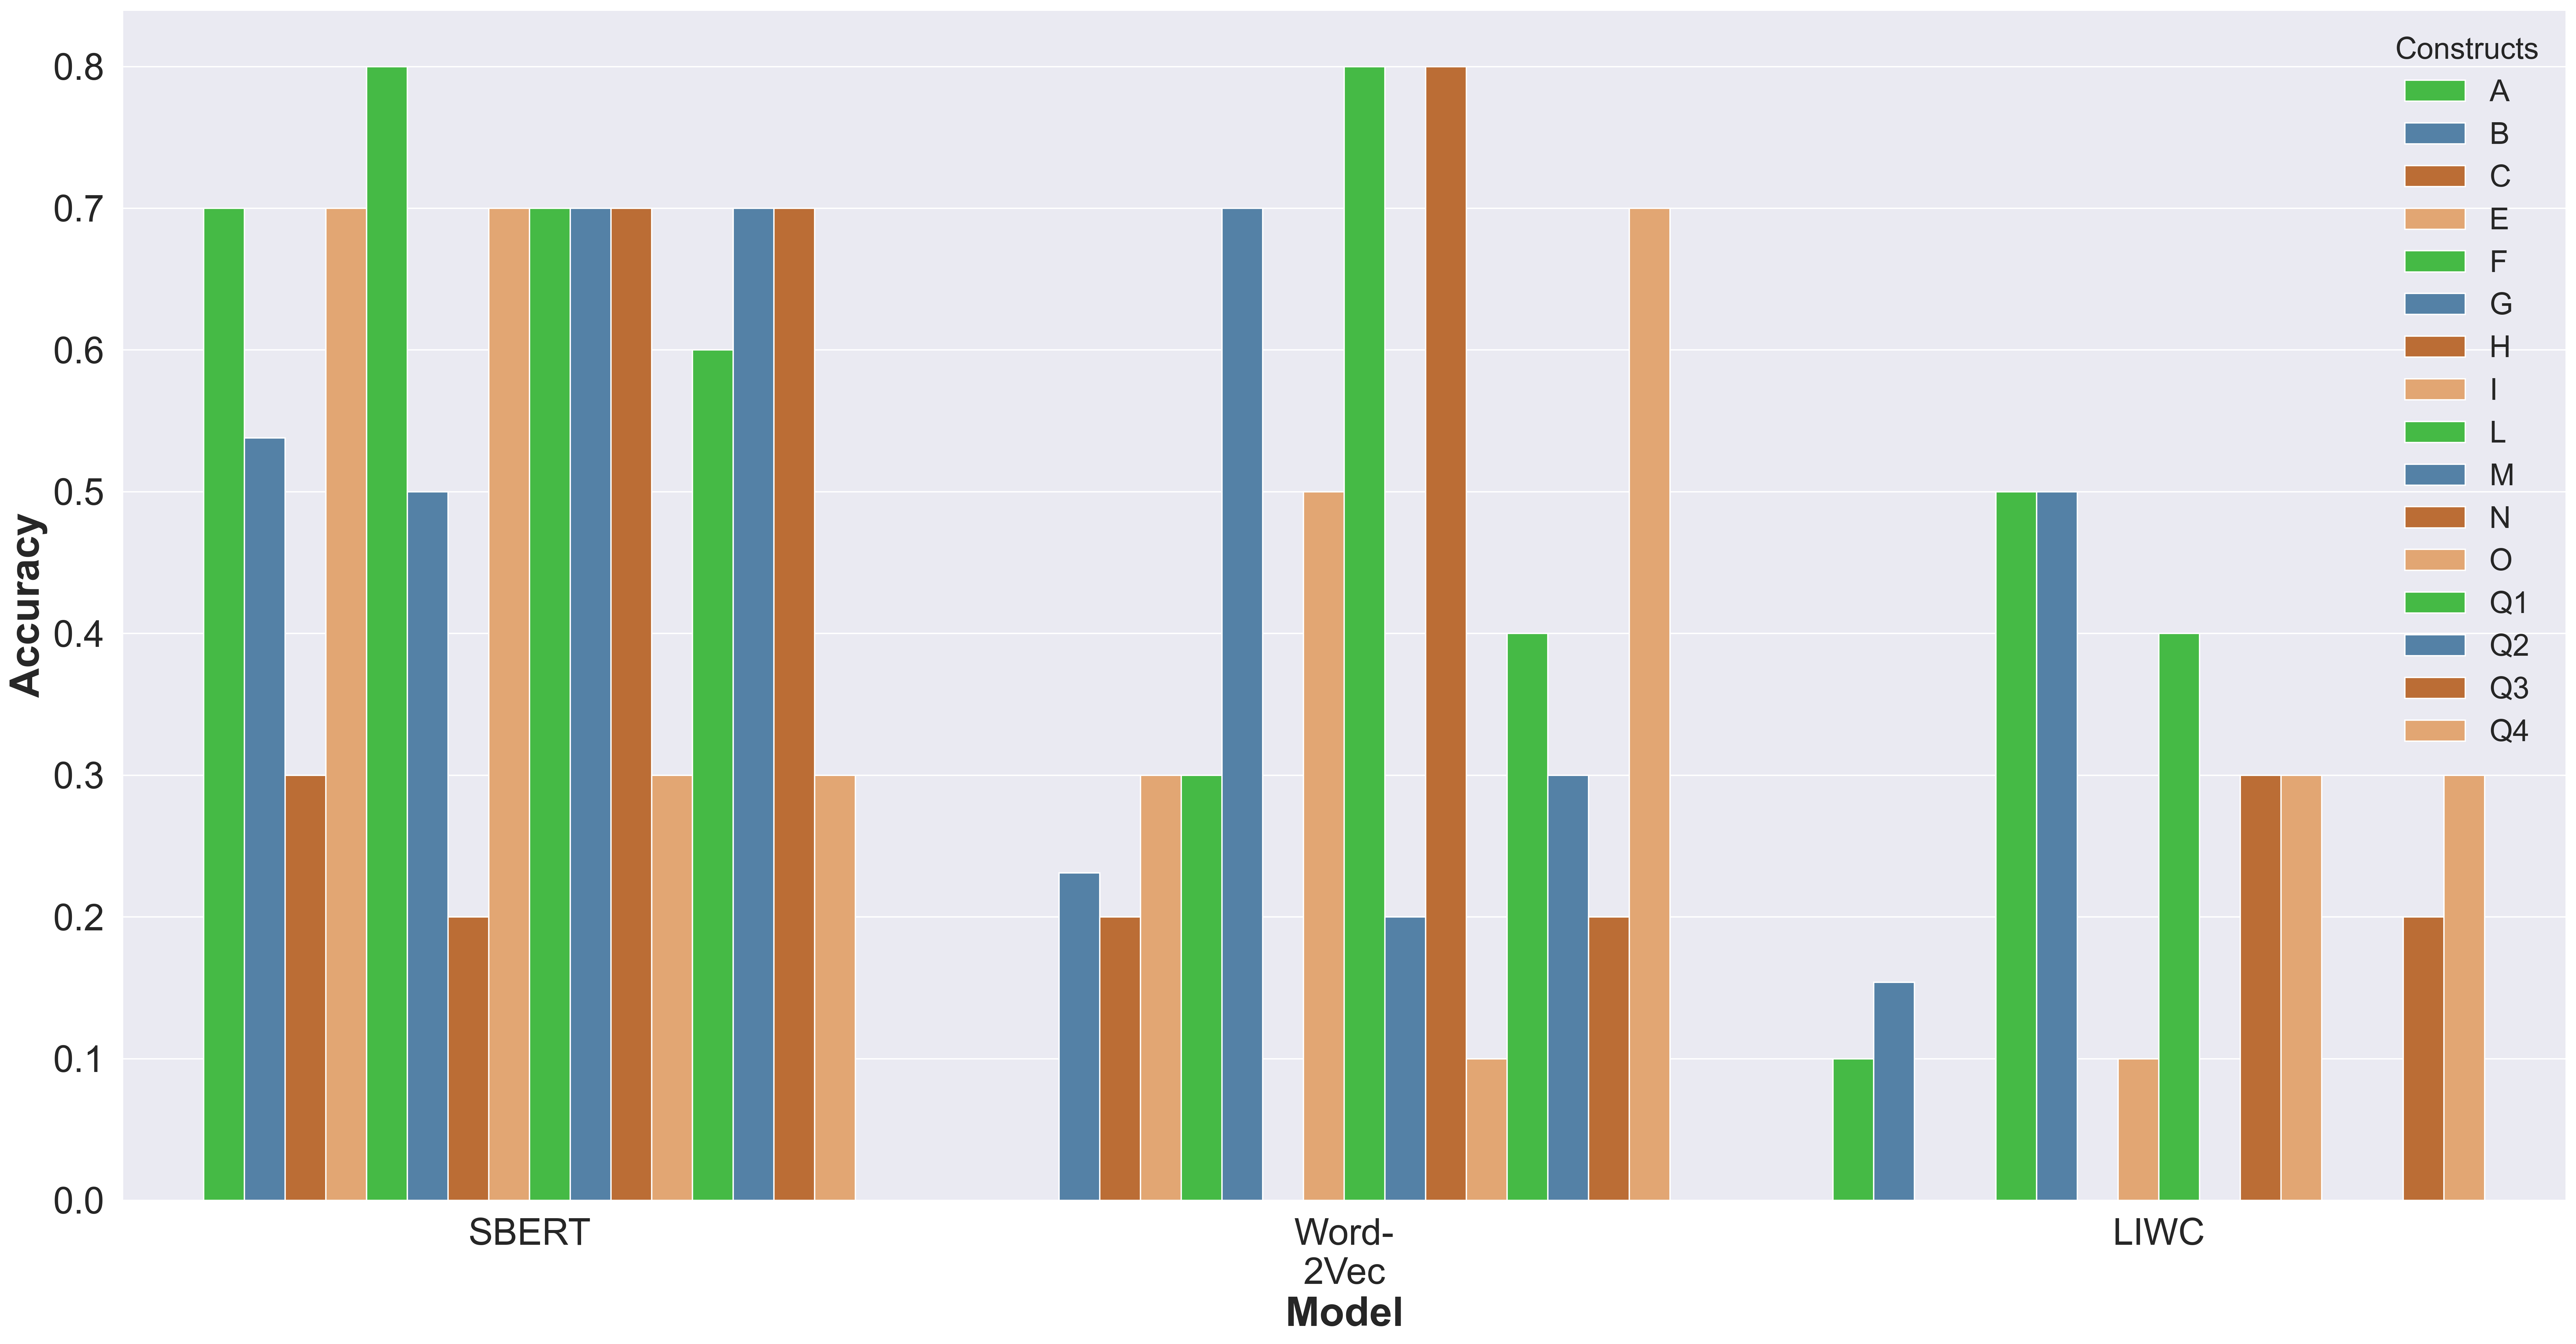

In [7]:
#Plot style and meta
plt.style.use('seaborn-v0_8')
sns.set_context('paper')
sns.set(font_scale = 1.5)

i = 1
d = datasets_con[i]

data = performance_con[(performance_con['Dataset']== d) & (performance_con['Model']!="Baseline")]
if i == 4:
    n = 5
    performance_con_IPIP = performance_con[performance_con.Dataset == "IPIP2"]
    top_constr = performance_con_IPIP[performance_con_IPIP.Model=="SBERT"].sort_values('Accuracy', ascending=False).groupby("Model").head(n).sort_index().Construct.tolist()
    bot_constr = performance_con_IPIP[performance_con_IPIP.Model=="SBERT"].sort_values('Accuracy', ascending=False).groupby("Model").tail(n).sort_index().Construct.tolist()
    data = performance_con_IPIP[(performance_con_IPIP.Construct.isin(top_constr)) | (performance_con_IPIP.Construct.isin(bot_constr))].sort_values("Accuracy", ascending=False)
#     data = performance_con_IPIP[(performance_con_IPIP.Construct.isin(top_constr))]
    fig  = plt.figure(figsize=(42, 24), dpi= 300)
else:
    fig  = plt.figure(figsize=(32, 16), dpi= 300)

ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "Word-\n2Vec", "LIWC"], hue = "Construct" , orient='v', data=data, 
                 palette=["limegreen", "steelblue", "chocolate", "sandybrown"])

plt.ylabel("Accuracy", fontweight='bold', fontsize=30)
plt.xlabel("Model", fontweight='bold', fontsize=30)
# plt.title(names_con[i] + " - Construct Prediction", fontsize=20, pad=20)
plt.yticks(size = 27)
plt.xticks(size = 27)
plt.legend(title="Constructs", fontsize=22, title_fontsize=22)


fig_name = "../plot_data/constructwise_performance_" + d + ".svg"
plt.title('', fontsize=20, fontweight="bold")
# plt.savefig(fig_name, bbox_inches='tight', format="svg", dpi=600)

Show performance as table (numeric values)

In [8]:
# Choose questionnaire and print construct names
i = "16PF"

#print construct names
print("Dataset: " + i)
print("List of construct:")
print(performance_con[performance_con.Dataset == i].Construct.drop_duplicates().tolist()) 
print("\nConstruct prediction performance:\n")

# Print performances for each embedding type over constructs
print(performance_con[performance_con.Dataset == i].to_string())
print("\nDirection prediction performance:\n")

# Print performances for each embedding type over keys
print(performance_dir[performance_dir.Dataset == i].to_string())

Dataset: 16PF
List of construct:
['A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'Q1', 'Q2', 'Q3', 'Q4']

Construct prediction performance:

   Dataset        Model  Accuracy     Target Construct
20    16PF        SBERT     0.700  construct         A
21    16PF        SBERT     0.538  construct         B
22    16PF        SBERT     0.300  construct         C
23    16PF        SBERT     0.700  construct         E
24    16PF        SBERT     0.800  construct         F
25    16PF        SBERT     0.500  construct         G
26    16PF        SBERT     0.200  construct         H
27    16PF        SBERT     0.700  construct         I
28    16PF        SBERT     0.700  construct         L
29    16PF        SBERT     0.700  construct         M
30    16PF        SBERT     0.700  construct         N
31    16PF        SBERT     0.300  construct         O
32    16PF        SBERT     0.600  construct        Q1
33    16PF        SBERT     0.700  construct        Q2
34    16PF        SBE

In [9]:
n = 20

# calculate performance accuracy over constructs and directions
performance_con_IPIP = performance_con[performance_con.Dataset == "IPIP2"]

top_constr = performance_con_IPIP[performance_con_IPIP.Model=="SBERT"].sort_values('Accuracy', ascending=False).groupby("Model").head(n).sort_index().Construct.tolist()
bot_constr = performance_con_IPIP[performance_con_IPIP.Model=="SBERT"].sort_values('Accuracy', ascending=False).groupby("Model").tail(n).sort_index().Construct.tolist()

# print accuracies over constructs
print("Construct prediction performance for top " + str(n) + " constructs:\n")
print(performance_con_IPIP[(performance_con_IPIP.Construct.isin(top_constr)) & (performance_con_IPIP.Model=="SBERT")])
print("\n")

print("Construct prediction performance for bottom " + str(n) + " constructs:\n")
# print accuracies over directions
print(performance_con_IPIP[(performance_con_IPIP.Construct.isin(bot_constr)) & (performance_con_IPIP.Model=="SBERT")])

Construct prediction performance for top 20 constructs:

    Dataset  Model  Accuracy     Target                        Construct
157   IPIP2  SBERT     0.941  construct       spirituality/religiousness
172   IPIP2  SBERT     1.000  construct                   health anxiety
181   IPIP2  SBERT     0.900  construct                        gratitude
197   IPIP2  SBERT     0.714  construct               cognitive problems
236   IPIP2  SBERT     1.000  construct            attention to emotions
272   IPIP2  SBERT     0.833  construct                 interest in pets
273   IPIP2  SBERT     0.700  construct                 science interest
277   IPIP2  SBERT     1.000  construct             interest in drinking
278   IPIP2  SBERT     1.000  construct         appearance-consciousness
290   IPIP2  SBERT     1.000  construct             interest in gambling
294   IPIP2  SBERT     0.833  construct            interest in gardening
296   IPIP2  SBERT     0.714  construct             interest in sho

### Construct misclassification analysis
Show items and their predicted constructs for a given true construct (label)

Load Data

In [4]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "ipip2"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4           #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings, responses)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(m, responses, X_pca_stand, folder, data)
y_constr = constrAssigned.construct.values #get construct values

#dicts to convert number to constructs and vice versa
constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
nrConstr = {value:key for key, value in constrNr.items()}
y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= constrAssigned.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)

Show items and their predicted and true constructs

In [11]:
construct = "conscientiousness"

items = constrAssigned[constrAssigned.construct.isin([construct])]
idx = items.index
predictions = pd.read_csv("../results/IPIP2/nonReversed/RidgeClass_1000_SENTENCEBERT_constructs.csv", index_col=0)
predictions.constructs = predictions.constructs.map(nrConstr)
predictions["original"] = constrAssigned.construct
predictions["text"] = constrAssigned.grammartical_item

predictions.loc[idx] 

,constructs,original,text
,,,
q11,conscientiousness,conscientiousness,i accomplish my work on time
q174,prudence,conscientiousness,i am careful to avoid making mistakes
q237,industriousness/perseverance/persistence,conscientiousness,i am exacting in my work
q396,workaholism,conscientiousness,i am often late to work
q818,norm violation,conscientiousness,i break rules
q961,organization,conscientiousness,i carry out my plans
q1000,industriousness/perseverance/persistence,conscientiousness,i complete tasks successfully
q1015,perfectionism,conscientiousness,i continue until everything is perfect
q1238,leadership,conscientiousness,i do not plan ahead


### Clustering

Load Data

In [17]:
d = "ipip"          #IPIP: all items, IPIP2: only assigned
e = "sentencebert"
nAssigned = 1       #0: only assigned items, #1: include non-assigned items

#choose data set, embeddings, encoding
folder, data = chooseData(d)        
#read in embeddings and save in vector
embeddings_df = pd.read_csv("../embeddings/" + folder + 'ipip_full_questions_embeddings_SENTENCEBERT.csv',index_col=0)
constrAssigned = pd.read_csv("../embeddings/" + folder + "ipip_questions_text.csv", encoding = 'utf-8',index_col=0)
X = embeddings_df.copy()

# ################################ Preprocess input data::
#Standardize for regression (wihtout PCA)
X_stand = pd.DataFrame(StandardScaler().fit_transform(X)) #standardize embeddings
#With PCA, for regression, 90% variance explained
X_pca = pd.DataFrame(PCA(0.9, random_state=0).fit_transform(X_stand),index=embeddings_df.index) 

Clustering based on question embeddings

In [19]:
#Number of clusters
k = 5
#include/exclude non assigned items
nAssigned = 1

if nAssigned == 0:
  plt_emb = X_pca.iloc[np.where(constrAssigned.construct != 'not assigned')]
else:
  plt_emb = X_pca

#K-Means clustering
model = KMeans(n_clusters = k, random_state=0, n_init = 10)
model.fit(plt_emb)
yhat = model.predict(plt_emb)

#create a dataframe that contains all items grouped by cluster
itemlist = constrAssigned.loc[plt_emb.index,'item'].drop_duplicates() #get the item texts
clusterOverview = pd.DataFrame(np.full((1,k),0))
clusters = []
for i in range(k):
  clusters.append(np.where(yhat==i)[0]) #get item indices for each cluster
find = list(range(len(itemlist)))
replace = itemlist
clusterOverview = pd.DataFrame(clusters).T.replace(find, replace) #replace the indices with item texts

#### Check which constructs are in the clusters

In [23]:
from collections import Counter
#### Check which constructs are in the clusters
#get the constructs from the IPIP that are in our new clusters
clusterConstructs = pd.DataFrame()
for i in range(clusterOverview.shape[1]):
  items = clusterOverview.iloc[:,i]
  #get construct
  constructs_idx = np.where(constrAssigned.item.isin(items))[0]
  constructs = constrAssigned.construct[constructs_idx].values
  #summarise which constructs occur how often
  summary = Counter(constructs)
  #get 5 (excluding "not assigned") most frequent one with number:
  clusterConstructs[i] = summary.most_common(10)
clusterConstructs

,0,1,2,3,4
0,"(not assigned, 359)","(not assigned, 425)","(not assigned, 336)","(not assigned, 361)","(not assigned, 236)"
1,"(depression, 17)","(dissociation, 26)","(creativity/originality, 25)","(aesthetic appreciation/artistic interests, 12)","(aesthetic appreciation/artistic interests, 7)"
2,"(anxiety, 10)","(conscientiousness, 7)","(organization, 18)","(sociability, 11)","(creativity/originality, 6)"
3,"(leadership, 7)","(unusual experiences, 7)","(assertiveness, 16)","(risk-taking/sensation-seeking/thrill-seeking,...","(sentimentality, 6)"
4,"(health anxiety, 6)","(morality, 6)","(leadership, 15)","(leadership, 9)","(forgiveness/mercy, 5)"
5,"(empathy, 6)","(prudence, 5)","(altruism, 12)","(gratitude, 8)","(conformity/dependence/need for approval, 5)"
6,"(flexibility, 6)","(humor/playfulness, 5)","(language mastery, 12)","(humor/playfulness, 8)","(extraversion, 5)"
7,"(negative expressivity, 6)","(equity/fairness, 5)","(conscientiousness, 11)","(modesty/humility, 7)","(prudence, 5)"
8,"(forgiveness/mercy, 6)","(creativity/originality, 5)","(intellect, 11)","(curiosity, 6)","(modesty/humility, 5)"
9,"(vitality/enthusiasm/zest, 5)","(cognitive problems, 5)","(industriousness/perseverance/persistence, 10)","(exhibitionism, 6)","(sociability, 5)"


Find items of interest in a cluster

In [24]:
cl = 0 #cluster
search = "love" #search word
mask = clusterOverview.iloc[:,cl].str.contains(search).fillna(False)
df = clusterOverview.loc[(mask),clusterOverview.columns[cl]].copy(deep=True)
df

125                         believe kids need tough love
132                    believe that kids need tough love
207      do not believe humans are truly capable of love
552    shift back and forth between strong love and s...
Name: 0, dtype: object